## 6-2. Implementation of  variational quantum eigensolver (VQE) using QURI Parts

In this section, we show an example of running the variational quantum eigensolver (VQE) on a simulator using QURI Parts for a quantum chemical Hamiltonian, and searching for the ground state.

requirements

- quri_parts.chem
- quri_parts.qulacs
- quri_parts.openfermion
- quri_parts.pyscf
- scipy
- numpy

In [ ]:
## Run if required libraries are not installed
## If you run on Google Colaboratory, igore the warning 'You must restart the runtime in order to use newly installed versions.'
## If you restart runtime, calculation may crash.
!pip install "quri_parts"
!pip install "quri_parts_qulacs"
!pip install "quri_parts_openfermion"
!pip install "quri_parts_pyscf"

## Run only in Google Colaboratory or (Linux or Mac) jupyter notebook environment
## Qulacs errors will be output normally.
!pip3 install wurlitzer
%load_ext wurlitzer

### Creation of Hamiltonian

Using the same procedure as in the previous section, Hamiltonian is calculated by PySCF .

In [1]:
from pyscf import gto, scf
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from quri_parts.core.operator import get_sparse_matrix
from scipy.sparse.linalg import eigsh

distance  = 0.977
mole = gto.M(
    atom=[["H", [0, 0, 0]],["H", [0, 0, distance]]],
    spin=0,
    charge=0,
    basis="sto-3g"
)
mf = scf.RHF(mole).run(verbose=0)

full_space, mo_eints = get_spin_mo_integrals_from_mole(mole, mf.mo_coeff)
jw_hamiltonian, _ = get_qubit_mapped_hamiltonian(full_space, mo_eints)

# Exact diagolization to find the exact ground state energy.
hamiltonian_matrix = get_sparse_matrix(jw_hamiltonian)
eigval, _ = eigsh(hamiltonian_matrix, k=2, which="SA") 

### Compose ansatz

Here we use the Hardware Efficient ansatz that is already built into QURI Parts. The quantum circuits were modeled after those used in experiments with superconducting qubits (A. Kandala _et. al._ , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246).

In [2]:
from quri_parts.algo.ansatz import HardwareEfficient
from quri_parts.openfermion.transforms import jordan_wigner

n_qubit = jordan_wigner.n_qubits_required(full_space.n_active_orb*2)
depth = n_qubit

def he_ansatz_circuit(n_qubit: int, depth: int) -> HardwareEfficient:
    return HardwareEfficient(n_qubit, depth)

### Define VQE cost function

As explained in [chapter 5-1](5.1_variational_quantum_eigensolver.ipynb), VQE obtains an approximate ground state by minimizing the following expectation of Hamiltonian of a state $|\psi(\theta)\rangle = U(\theta)|0\rangle$ which is output from quantum circuit $U(\theta)$ with a parameter .

$$\langle H (\theta)\rangle = \langle\psi(\theta)|H|\psi(\theta)\rangle$$

In [3]:
import numpy as np
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
from quri_parts.core.utils.recording import Recorder, recordable

estimator = create_qulacs_vector_estimator()

@recordable
def cost(recorder: Recorder, theta_list: list[float]) -> float:
    """The cost function to be optimized. 

    - The recordable decorator and the recorder.info call is not relevant to physics.
    It is a convenient feature in QURI Parts that allow users to record intermediate results.
    We will use it to record the cost history during VQE.

    - You do not need to pass in anything to the recorder due to the `recordable` decorator.
    You may simply treat it as a function with `theta_list` as its only parameter.
    """
    ansatz_circuit = he_ansatz_circuit(n_qubit, depth)
    state = quantum_state(
        n_qubit,
        circuit=ansatz_circuit.bind_parameters(theta_list)
    )
    est = estimator(jw_hamiltonian, state).value.real
    recorder.info("est", est)
    return est

cost(
    np.random.random(
        he_ansatz_circuit(n_qubit, depth).parameter_count
    )
)

-0.09192014961770327

Before jumping into the VQE procedure, let's temporarily digress to an optional step if you wish to use scipy to minimize. This step is customizing our own gradient estimation function. Though this step is optional, it can potentially provide better performance so that the minimization does not take much time. Please check out the QURI Parts tutorial page on [Variational Algorithms](https://quri-parts.qunasys.com/tutorials/variational) for details on gradient estimators. Here, we provide an example of a customized gradient function with QURI Parts.

In [4]:
from typing import Sequence
from quri_parts.qulacs.estimator import create_qulacs_vector_concurrent_parametric_estimator
from quri_parts.core.estimator.gradient import create_numerical_gradient_estimator


def grad_func(theta_list: Sequence[float]) -> Sequence[float]:
    """Gradient of the cost function with respect to the circuit parameters
    theta.
    """
    param_estimator = create_qulacs_vector_concurrent_parametric_estimator()
    grad_estimator = create_numerical_gradient_estimator(param_estimator, 1e-4)
    
    ansatz_circuit = he_ansatz_circuit(n_qubit, depth)
    ansatz_state = quantum_state(n_qubit, circuit=ansatz_circuit)
    return np.array(grad_estimator(jw_hamiltonian, ansatz_state, theta_list).values).real


### Execute VQE
Now that we're ready, let's run VQE. For optimization, the BFGS method implemented in scipy is used, and the initial parameters are randomly selected. It should finish in tens of seconds.

In [14]:
from scipy.optimize import minimize
from quri_parts.core.utils.recording import RecordSession, INFO

# Optimization parameters
init_theta_list = np.random.random(2*n_qubit*(depth+1))*1e-1
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

# Run VQE and record the cost while the optimization loop is executed.
recording_session = RecordSession()
recording_session.set_level(INFO, cost)

with recording_session.start():
    opt = minimize(cost, init_theta_list, jac=grad_func,  method=method)

In [15]:
def get_history(session: RecordSession) -> list[float]:
    """Retrieve hamiltonian expectation value from recording session.
    """
    cost_history = []
    for group in session.get_records().get_history(cost):
        entries = group.entries
        cost_history.append(entries[0].data[1])
    return cost_history

cost_history = get_history(recording_session)

Plotting the execution result, we can see that it has converged to the correct solution.

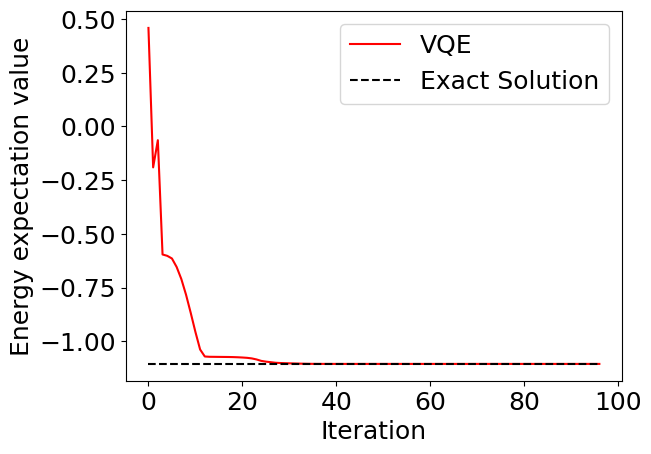

In [16]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="VQE")
plt.plot(range(len(cost_history)), [eigval[0]]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

##### VQE using QURI Parts

As explained in the Quantum Circuit Learning chapter, we can use QURI Parts instead of scipy to perform our optimization procedure. Here, we deomonstrate how to do VQE with QURI Parts.

In [8]:
from typing import Callable, Sequence
from quri_parts.algo.optimizer import OptimizerStatus, OptimizerState, Optimizer

def vqe(
    init_params: Sequence[float],
    cost_fn: Callable[[Sequence[float]], float],
    grad_fn: Callable[[Sequence[float]], Sequence[float]],
    optimizer: Optimizer,
) -> OptimizerState:
    """Optimization loop for performing VQE.
    """
    opt_state = optimizer.get_init_state(init_params)

    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)

        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break
    return opt_state

In [9]:
from quri_parts.algo.optimizer import LBFGS
from quri_parts.core.utils.recording import RecordSession, INFO

recording_session = RecordSession()
recording_session.set_level(INFO, cost)

with recording_session.start():
    result_qp = vqe(init_theta_list, cost, grad_func, LBFGS())

qp_cost_history = get_history(recording_session)

Optimizer converged


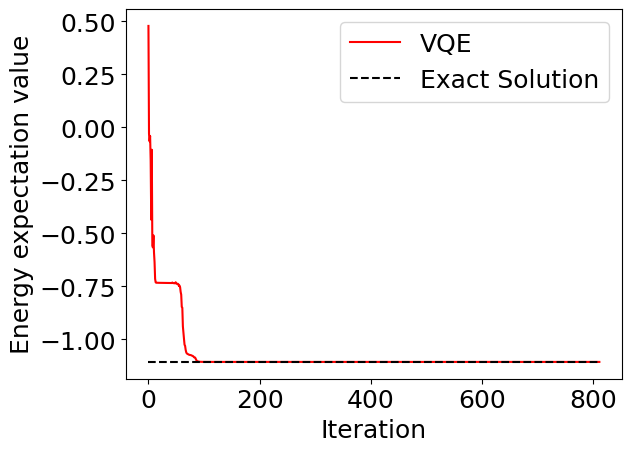

In [10]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 18
plt.plot(qp_cost_history, color="red", label="VQE")
plt.plot(range(len(qp_cost_history)), [eigval[0]]*len(qp_cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

Encouraged readers should calculate the ground state by changing `distance`, the distance between the hydrogen atoms and find the interatomic distance at which the hydrogen molecule is most stable. (It should be about 0.74 Angstroms, depending on ansatz performance.)